# LeNet-5 CNN & _LARS_ optimizer: MNIST & PyTorch


LARS optimizer was introduced by Yang You et al. in [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888)

Layer-wise Adaptive Rate Scaling, or LARS, is a large batch optimization technique. There are two notable differences between LARS and other adaptive algorithms such as Adam or RMSProp:
1. first, LARS uses a separate learning rate for each layer and not for each weight.
2. And second, the magnitude of the update is controlled with respect to the weight norm for better control of training speed.



- [apex LARS optimizer](https://github.com/NVIDIA/apex/blob/master/apex/parallel/LARC.py)
- [SwAV official GitHub repo](https://github.com/facebookresearch/swav/blob/main/main_swav.py)
- [LARS explained](https://paperswithcode.com/method/lars)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from LARC import LARC

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.1.1+cpu
Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu


In [3]:
# Hyper-parameters-
num_epochs = 50
batch_size = 256
learning_rate = 0.001

In [4]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [5]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    root = '/home/amajumdar/Downloads/.data/', train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = "/home/amajumdar/Downloads/.data/", train = False,
    transform = transforms_apply
)

In [6]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [7]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [8]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [9]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f} &"
      f"std dev = {train_dataset.data.float().std() / 255:.4f}"
     )

mean = 0.1307 &std dev = 0.3081


In [10]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))
print(f"images.shape: {images.shape}")

# De-normalize the batch of images-
images *= 255.0

images.shape: torch.Size([256, 1, 28, 28])


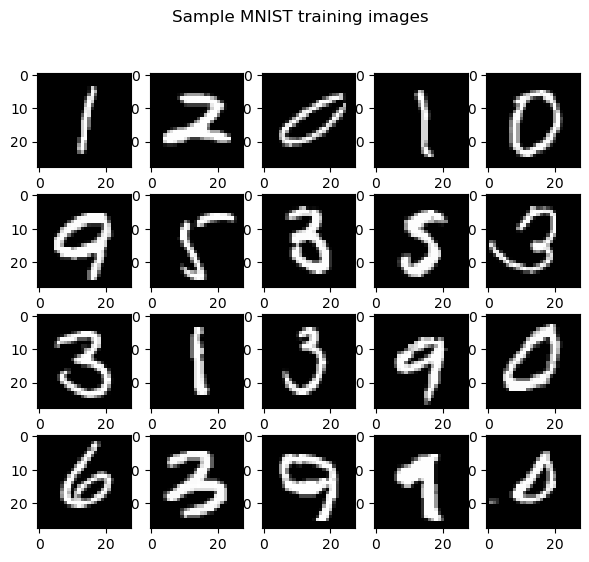

In [14]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [15]:
del images, labels

In [11]:
class LeNet_CNN(nn.Module):
    def __init__(self):
        super(LeNet_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.dense = nn.Linear(
            in_features = 64, out_features = 10,
            bias = True
        )
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # print(f"before flatten, x.shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        x = self.dense(x)
        return x
        

In [12]:
# Initialize LeNet-5 CNN architecture-
model = LeNet_CNN().to(device)

In [13]:
# Define loss function and optimizer-
loss_fn = nn.CrossEntropyLoss()

In [14]:
# build optimizer
optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.01, momentum = 0.9,
    weight_decay = 5e-4,
)

optimizer = LARC(
    optimizer = optimizer, trust_coefficient = 0.001,
    clip = False
)

In [15]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss_fn(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [16]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [17]:
# Python3 dict to contain training metrics-
training_history = {}

# Initialize parameters saving 'best' models-
best_val_acc = 0

In [18]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}%"
          # f" & LR = {optimizer.param_groups[0]['lr']:.4f}
          f"\n")
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        # 'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "LeNet5_best_model.pth")
         

Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.06batch/s, val_acc=24.6, val_loss=2.13]



epoch: 1 training loss = 2.3340, training accuracy = 17.11%, val_loss = 2.1285, val_accuracy = 24.63%

Saving model with highest val_acc = 24.6300%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.68batch/s, val_acc=36.8, val_loss=1.86]



epoch: 2 training loss = 2.0023, training accuracy = 30.70%, val_loss = 1.8628, val_accuracy = 36.81%

Saving model with highest val_acc = 36.8100%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.36batch/s, val_acc=47.9, val_loss=1.57]



epoch: 3 training loss = 1.7269, training accuracy = 41.66%, val_loss = 1.5685, val_accuracy = 47.94%

Saving model with highest val_acc = 47.9400%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.99batch/s, val_acc=58.3, val_loss=1.28]



epoch: 4 training loss = 1.4321, training accuracy = 53.26%, val_loss = 1.2767, val_accuracy = 58.27%

Saving model with highest val_acc = 58.2700%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.79batch/s, val_acc=66.6, val_loss=1.04]



epoch: 5 training loss = 1.1674, training accuracy = 62.93%, val_loss = 1.0418, val_accuracy = 66.56%

Saving model with highest val_acc = 66.5600%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.32batch/s, val_acc=72.1, val_loss=0.881]



epoch: 6 training loss = 0.9723, training accuracy = 69.16%, val_loss = 0.8809, val_accuracy = 72.14%

Saving model with highest val_acc = 72.1400%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.05batch/s, val_acc=76.1, val_loss=0.771]



epoch: 7 training loss = 0.8424, training accuracy = 73.47%, val_loss = 0.7708, val_accuracy = 76.13%

Saving model with highest val_acc = 76.1300%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.14batch/s, val_acc=78.8, val_loss=0.691]



epoch: 8 training loss = 0.7508, training accuracy = 76.53%, val_loss = 0.6907, val_accuracy = 78.79%

Saving model with highest val_acc = 78.7900%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.23batch/s, val_acc=80.7, val_loss=0.63]



epoch: 9 training loss = 0.6826, training accuracy = 78.84%, val_loss = 0.6300, val_accuracy = 80.66%

Saving model with highest val_acc = 80.6600%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.74batch/s, val_acc=82.2, val_loss=0.584]



epoch: 10 training loss = 0.6292, training accuracy = 80.63%, val_loss = 0.5837, val_accuracy = 82.15%

Saving model with highest val_acc = 82.1500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.95batch/s, val_acc=83.2, val_loss=0.546]



epoch: 11 training loss = 0.5868, training accuracy = 82.05%, val_loss = 0.5464, val_accuracy = 83.19%

Saving model with highest val_acc = 83.1900%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.19batch/s, val_acc=84.3, val_loss=0.515]



epoch: 12 training loss = 0.5519, training accuracy = 83.23%, val_loss = 0.5154, val_accuracy = 84.32%

Saving model with highest val_acc = 84.3200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.88batch/s, val_acc=85.1, val_loss=0.489]



epoch: 13 training loss = 0.5217, training accuracy = 84.22%, val_loss = 0.4886, val_accuracy = 85.14%

Saving model with highest val_acc = 85.1400%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.87batch/s, val_acc=86, val_loss=0.465]



epoch: 14 training loss = 0.4953, training accuracy = 85.08%, val_loss = 0.4653, val_accuracy = 85.96%

Saving model with highest val_acc = 85.9600%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.56batch/s, val_acc=86.6, val_loss=0.446]



epoch: 15 training loss = 0.4726, training accuracy = 85.82%, val_loss = 0.4459, val_accuracy = 86.58%

Saving model with highest val_acc = 86.5800%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.57batch/s, val_acc=87, val_loss=0.428]



epoch: 16 training loss = 0.4531, training accuracy = 86.44%, val_loss = 0.4282, val_accuracy = 86.97%

Saving model with highest val_acc = 86.9700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.74batch/s, val_acc=87.4, val_loss=0.412]



epoch: 17 training loss = 0.4358, training accuracy = 86.99%, val_loss = 0.4117, val_accuracy = 87.39%

Saving model with highest val_acc = 87.3900%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.92batch/s, val_acc=87.9, val_loss=0.397]



epoch: 18 training loss = 0.4202, training accuracy = 87.53%, val_loss = 0.3974, val_accuracy = 87.88%

Saving model with highest val_acc = 87.8800%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.69batch/s, val_acc=88.3, val_loss=0.384]



epoch: 19 training loss = 0.4061, training accuracy = 87.97%, val_loss = 0.3844, val_accuracy = 88.35%

Saving model with highest val_acc = 88.3500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.01batch/s, val_acc=88.8, val_loss=0.373]



epoch: 20 training loss = 0.3933, training accuracy = 88.33%, val_loss = 0.3729, val_accuracy = 88.80%

Saving model with highest val_acc = 88.8000%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.84batch/s, val_acc=89, val_loss=0.361]



epoch: 21 training loss = 0.3816, training accuracy = 88.69%, val_loss = 0.3610, val_accuracy = 89.02%

Saving model with highest val_acc = 89.0200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.74batch/s, val_acc=89.3, val_loss=0.352]



epoch: 22 training loss = 0.3708, training accuracy = 89.03%, val_loss = 0.3519, val_accuracy = 89.28%

Saving model with highest val_acc = 89.2800%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.48batch/s, val_acc=89.7, val_loss=0.343]



epoch: 23 training loss = 0.3610, training accuracy = 89.34%, val_loss = 0.3433, val_accuracy = 89.72%

Saving model with highest val_acc = 89.7200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.26batch/s, val_acc=89.9, val_loss=0.334]



epoch: 24 training loss = 0.3519, training accuracy = 89.64%, val_loss = 0.3340, val_accuracy = 89.93%

Saving model with highest val_acc = 89.9300%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.71batch/s, val_acc=90.1, val_loss=0.326]



epoch: 25 training loss = 0.3436, training accuracy = 89.95%, val_loss = 0.3263, val_accuracy = 90.14%

Saving model with highest val_acc = 90.1400%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.17batch/s, val_acc=90.3, val_loss=0.319]



epoch: 26 training loss = 0.3361, training accuracy = 90.18%, val_loss = 0.3190, val_accuracy = 90.31%

Saving model with highest val_acc = 90.3100%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.21batch/s, val_acc=90.5, val_loss=0.312]



epoch: 27 training loss = 0.3287, training accuracy = 90.42%, val_loss = 0.3122, val_accuracy = 90.52%

Saving model with highest val_acc = 90.5200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.56batch/s, val_acc=90.6, val_loss=0.305]



epoch: 28 training loss = 0.3220, training accuracy = 90.57%, val_loss = 0.3051, val_accuracy = 90.61%

Saving model with highest val_acc = 90.6100%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.67batch/s, val_acc=90.8, val_loss=0.299]



epoch: 29 training loss = 0.3155, training accuracy = 90.79%, val_loss = 0.2992, val_accuracy = 90.84%

Saving model with highest val_acc = 90.8400%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.50batch/s, val_acc=91, val_loss=0.294]



epoch: 30 training loss = 0.3094, training accuracy = 90.96%, val_loss = 0.2936, val_accuracy = 91.04%

Saving model with highest val_acc = 91.0400%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.21batch/s, val_acc=91.2, val_loss=0.288]



epoch: 31 training loss = 0.3036, training accuracy = 91.16%, val_loss = 0.2877, val_accuracy = 91.20%

Saving model with highest val_acc = 91.2000%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.13batch/s, val_acc=91.3, val_loss=0.283]



epoch: 32 training loss = 0.2982, training accuracy = 91.31%, val_loss = 0.2833, val_accuracy = 91.30%

Saving model with highest val_acc = 91.3000%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.08batch/s, val_acc=91.5, val_loss=0.279]



epoch: 33 training loss = 0.2928, training accuracy = 91.42%, val_loss = 0.2786, val_accuracy = 91.53%

Saving model with highest val_acc = 91.5300%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.58batch/s, val_acc=91.7, val_loss=0.273]



epoch: 34 training loss = 0.2879, training accuracy = 91.55%, val_loss = 0.2733, val_accuracy = 91.68%

Saving model with highest val_acc = 91.6800%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.19batch/s, val_acc=91.8, val_loss=0.27]



epoch: 35 training loss = 0.2831, training accuracy = 91.70%, val_loss = 0.2696, val_accuracy = 91.76%

Saving model with highest val_acc = 91.7600%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.49batch/s, val_acc=92, val_loss=0.265]



epoch: 36 training loss = 0.2787, training accuracy = 91.79%, val_loss = 0.2653, val_accuracy = 91.99%

Saving model with highest val_acc = 91.9900%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.64batch/s, val_acc=92, val_loss=0.261]



epoch: 37 training loss = 0.2744, training accuracy = 91.95%, val_loss = 0.2612, val_accuracy = 91.99%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.67batch/s, val_acc=92.1, val_loss=0.257]



epoch: 38 training loss = 0.2703, training accuracy = 92.05%, val_loss = 0.2568, val_accuracy = 92.11%

Saving model with highest val_acc = 92.1100%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.22batch/s, val_acc=92.2, val_loss=0.253]



epoch: 39 training loss = 0.2661, training accuracy = 92.16%, val_loss = 0.2527, val_accuracy = 92.17%

Saving model with highest val_acc = 92.1700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.51batch/s, val_acc=92.4, val_loss=0.249]



epoch: 40 training loss = 0.2623, training accuracy = 92.27%, val_loss = 0.2492, val_accuracy = 92.38%

Saving model with highest val_acc = 92.3800%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.02batch/s, val_acc=92.5, val_loss=0.246]



epoch: 41 training loss = 0.2584, training accuracy = 92.38%, val_loss = 0.2457, val_accuracy = 92.45%

Saving model with highest val_acc = 92.4500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.75batch/s, val_acc=92.5, val_loss=0.243]



epoch: 42 training loss = 0.2550, training accuracy = 92.47%, val_loss = 0.2427, val_accuracy = 92.53%

Saving model with highest val_acc = 92.5300%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.99batch/s, val_acc=92.7, val_loss=0.239]



epoch: 43 training loss = 0.2513, training accuracy = 92.50%, val_loss = 0.2390, val_accuracy = 92.65%

Saving model with highest val_acc = 92.6500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.24batch/s, val_acc=92.7, val_loss=0.236]



epoch: 44 training loss = 0.2482, training accuracy = 92.64%, val_loss = 0.2360, val_accuracy = 92.72%

Saving model with highest val_acc = 92.7200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.61batch/s, val_acc=92.8, val_loss=0.233]



epoch: 45 training loss = 0.2448, training accuracy = 92.75%, val_loss = 0.2331, val_accuracy = 92.80%

Saving model with highest val_acc = 92.8000%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.66batch/s, val_acc=92.9, val_loss=0.23]



epoch: 46 training loss = 0.2418, training accuracy = 92.83%, val_loss = 0.2301, val_accuracy = 92.89%

Saving model with highest val_acc = 92.8900%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.14batch/s, val_acc=92.9, val_loss=0.227]



epoch: 47 training loss = 0.2387, training accuracy = 92.90%, val_loss = 0.2272, val_accuracy = 92.91%

Saving model with highest val_acc = 92.9100%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.19batch/s, val_acc=93.1, val_loss=0.225]



epoch: 48 training loss = 0.2357, training accuracy = 93.01%, val_loss = 0.2249, val_accuracy = 93.10%

Saving model with highest val_acc = 93.1000%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.30batch/s, val_acc=93.2, val_loss=0.222]



epoch: 49 training loss = 0.2329, training accuracy = 93.10%, val_loss = 0.2218, val_accuracy = 93.25%

Saving model with highest val_acc = 93.2500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.92batch/s, val_acc=93.3, val_loss=0.219]


epoch: 50 training loss = 0.2300, training accuracy = 93.18%, val_loss = 0.2190, val_accuracy = 93.33%

Saving model with highest val_acc = 93.3300%



In [19]:
# Save training metrics as Python3 history for later analysis-
with open("LeNet5_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

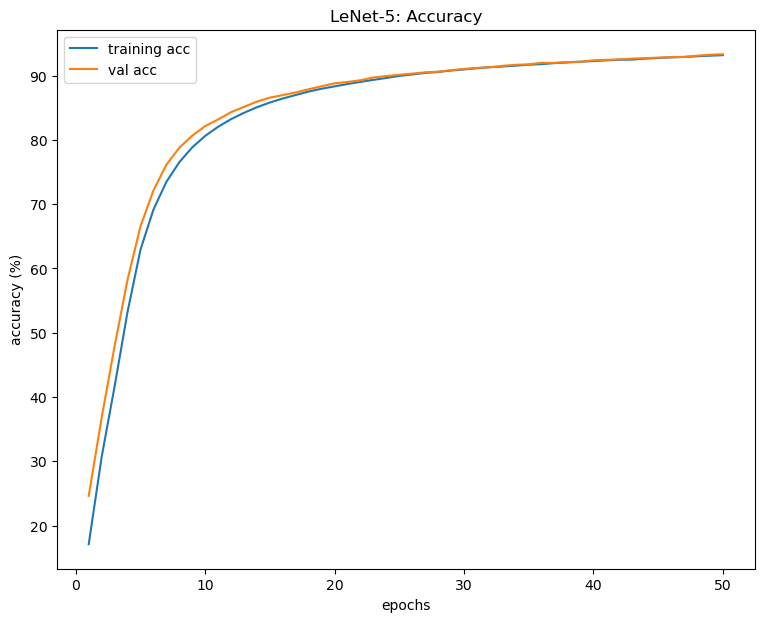

In [20]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['acc'] for k in training_history.keys()], label = 'training acc')
plt.plot(list(training_history.keys()), [training_history[k]['val_acc'] for k in training_history.keys()], label = 'val acc')
plt.title("LeNet-5: Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

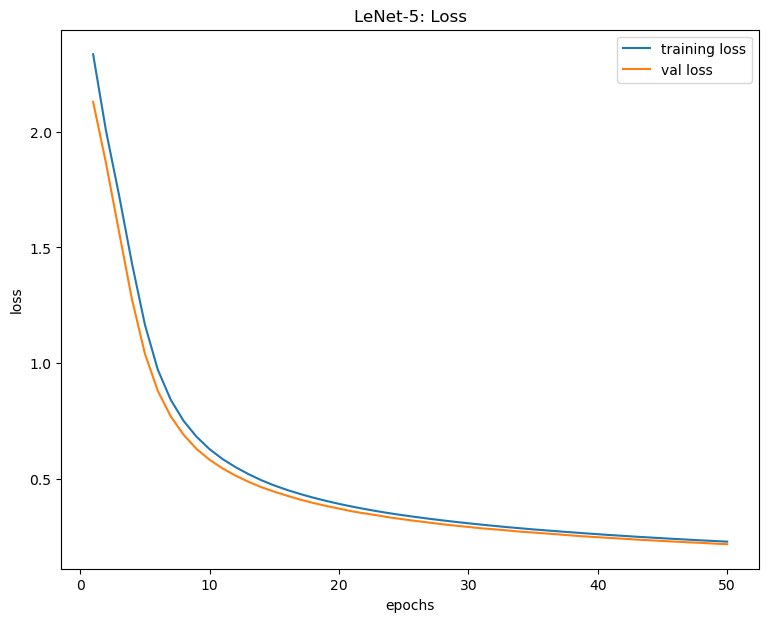

In [21]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['loss'] for k in training_history.keys()], label = 'training loss')
plt.plot(list(training_history.keys()), [training_history[k]['val_loss'] for k in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-5: Loss")
plt.show()

In [ ]:
"""
plt.figure(figsize = (9, 7))
plt.plot(list(training_history.keys()), [training_history[k]['lr'] for k in training_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-5: Learning-Rate")
plt.show()
"""

In [41]:
# Save LARS optimizer-
torch.save(optimizer.state_dict(), 'LeNet5_bestmodel_LARS_optim.pth')

In [23]:
optimizer.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [30]:
optimizer.state_dict()['state'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
optimizer.state_dict()['param_groups'][0].keys()

dict_keys(['lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach', 'differentiable', 'params'])

In [36]:
optimizer.state_dict()['param_groups'][0]

{'lr': 0.01,
 'momentum': 0.9,
 'dampening': 0,
 'weight_decay': 0.0005,
 'nesterov': False,
 'maximize': False,
 'foreach': None,
 'differentiable': False,
 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [37]:
optimizer.state_dict()['param_groups'][0]['params']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [39]:
optimizer.state_dict()['state'][0].keys()

dict_keys(['momentum_buffer'])